<a href="https://colab.research.google.com/github/CarloGiorgio/carlogiorgio/blob/master/Optics/Mach-Zehnder_BPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BPM 2 Propagazione anisotropa
## Creazione Mach-Zehnder


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
from matplotlib import cm
import time

from cupyx.scipy.special import erf
fft,ifft=cp.fft.fft,cp.fft.ifft

In [0]:
#Parametri fisici onda

Ip=(1)^2; 							
l=0.5*10**(-6);			
k=2*np.pi/l;  				
n0=1.5; 
 						
Dn=8e-4         
w0=15e-6  
Guide_width=30e-6
MaxD=3e-5;                
StepLength=0.012  
LengthSeparation=0.015  

dn_michelson=2*np.sqrt(2)*0.0000166667
Dz_michelson=15e-3
pos=0.

In [0]:
#Parametri domini spaziali

Lz=0.12					
Lx=400e-6 	

nx=1024*2   
nz=800*2

In [4]:
#Reticolo spaziale
z=cp.linspace(0,Lz+Lz/nz,nz)
x=-Lx/2+cp.arange(0,nx)*Lx/nx

#Utili per i plot
xp=cp.asnumpy(x)
zp=cp.asnumpy(z)

X,Z=cp.meshgrid(x,z)

Xp,Zp=np.meshgrid(xp,zp)
print(X.shape,Z.shape)

(1600, 2048) (1600, 2048)


In [5]:
#Dominio trasformata
ntx=0
kx = cp.zeros(nx)                                          
for nn in range(nx):
    ikx = nn - ntx
    kx[nn] = 2*np.pi/Lx*ikx
    if nn + 1 - nx/2 == 0 :
      ntx = nx
print(kx.shape)

(2048,)


In [6]:
#Variazioni degli spostamenti lungo z

dx1=MaxD*(0.5+0.5*erf((z-StepLength*2)/(StepLength)))*(
    0.5-0.5*erf((z-LengthSeparation-StepLength*5)/StepLength))

#dx2=-MaxD*(0.5+0.5*erf((z-StepLength*2)/(StepLength)))*(
#    0.5-0.5*erf((z-LengthSeparation-StepLength*5)/StepLength))
dx2=-dx1.copy()
print(dx2.shape,dx1.shape)

(1600,) (1600,)


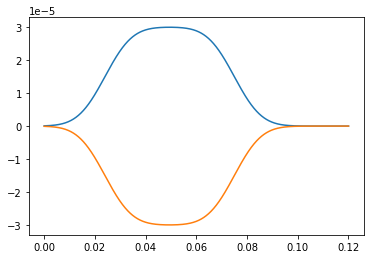

In [7]:
plt.plot(zp,cp.asnumpy(dx1))
plt.plot(zp,cp.asnumpy(dx2))

In [0]:
# Variazioni delle riflessioni
R=w0/np.sqrt(2)

In [0]:
#Individua una particolare fibra di mach zender
def fiber(dx,dn):
  dna=cp.asnumpy(dn)
  dxa=cp.asnumpy(dx)
  dk=np.tile(dxa,(nx,1)).T
  dna=dna*np.heaviside(Xp+dk+Guide_width/2,0)*np.heaviside(
      -Xp-dk+Guide_width/2,0)
  return(cp.asarray(dna))

def fiber_g(dx,dn):
  dk=cp.tile(dx,(nx,1)).T
  dn=dn*cp.exp(-((X+dk)/(Guide_width/2))**12) #gaussiano spinto
  return(dn)

def fiber_p(dx,dn):
  dna=cp.asnumpy(dn)
  dxa=cp.asnumpy(dx)
  dk=np.tile(dxa,(nx,1)).T
  dna=dna*(1-((Xp+dk)/R)**2)*np.heaviside(1-((Xp+dk)/R)**2,0)
  return(cp.asarray(dna))


# definizione della fibra in base alla funzione

def shape(name,amp=Dn):

  dn1=amp*cp.ones((nz,nx))
  dnp=(1+dn_michelson*cp.exp(-(
      Z-z[np.argmax(dx1)])**82/((Dz_michelson/2)**82)))
  dn2=dn1.copy()

  if name=='heav':
    dn1=fiber(dx1,dn1)
    dn2=fiber(dx2,dn2)

  if name=='gaus':
    dn1=fiber_g(dx1,dn1)
    dn2=fiber_g(dx2,dn2)

  if name=='para':
    dn1=fiber_p(dx1,dn1)
    dn2=fiber_p(dx2,dn2)

  dn2=dn2*dnp
  dn=np.maximum(dn1,dn2)
  return(cp.asarray(dn))

In [24]:
dnp=cp.asnumpy(shape('heav'))
print(dnp.shape)

Error in callback <function flush_figures at 0x7f463c813598> (for post_execute):


KeyboardInterrupt: ignored

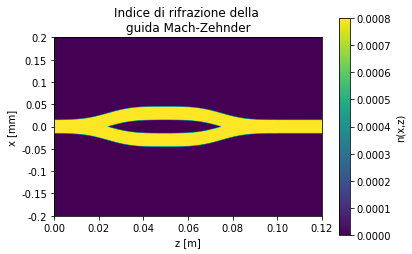

In [210]:
fig,ax=plt.subplots()
col=ax.imshow(dnp.T,extent=[0,0.12,-0.04,0.04])
ax.set(title='Indice di rifrazione della \nguida Mach-Zehnder',
       xlabel='z [m]',ylabel=r'x [mm]')
ax.set_yticklabels(np.arange(-2,2.5,0.5)/10)
cbar=fig.colorbar(col)
cbar.set_label('n(x,z)')
fig.savefig('guide.pdf')

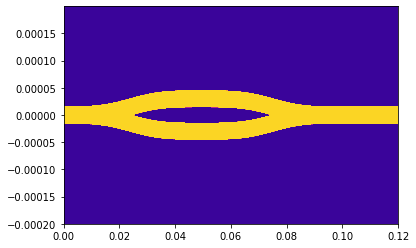

In [23]:
a.contourf(Zp,Xp,dnp,cmap=cm.plasma)

In [0]:
#Propagazione del campo
def propa(Ip,dn,i,prop,kp=k):
    Ipf=cp.zeros(Ip.shape[0],dtype=complex)
    Ipf=fft(Ip,n=nx)*prop
    Ip=ifft(Ipf,n=nx)
    Ip=Ip*cp.exp(-1j*(k*Lz/nz*dn[i,:]))
    Ipf=fft(Ip,n=nx)*prop
    Ip=ifft(Ipf,n=nx)
    return(Ip)

In [91]:
## Funzione che raccoglie tutte le variabili 
# Integrazione immediata
# Restituisce come array numpy perché è più facile da plottare

def mach_zender(Ip=1,l=0.5e-6,n0=1.5,w0=15e-6,name='heav',it=True):
  tstart=time.time()
  k=2*np.pi/l;  
  prop=cp.exp(1j*(kx*kx*Lz/4/nz/k/n0))
  I=Ip**0.5*cp.exp(-((x-pos)/(w0))**2)
  R=w0/np.sqrt(2)
  dn=shape(name)
  IC=cp.zeros((nx,nz),dtype=complex)
  IC[:,0]=I
  IP=cp.zeros((nx,nz))
  IP[:,0]=cp.abs(I)**2
  for i in range(1,nz):
    I=propa(I,dn=dn,i=i,prop=prop,kp=k)
    IC[:,i]=I
    IP[:,i]=cp.abs(I)**2
  
  print('Differenze energie',sum(IP[:,0])-sum(IP[:,-1]))
  print("Integrazione completata!\nDurata:",time.time()-tstart)

  if it:
    return(cp.asnumpy(IP),cp.asnumpy(IC))
  else:
    return(cp.asnumpy(IC))

IP,IC=mach_zender(Ip,name='heav')


Differenze energie -3.108198143308982e-10
Integrazione completata!
Durata: 3.7552316188812256


In [0]:
from matplotlib.colors import LinearSegmentedColormap
'''
Spercial thanks to @Raeuben
'''

'''
To make more realistic plots we define a function
returning approzimated colormap from wavelength.
There is not a simple form for it, because of the
complex mechanisms of human vision and trichromy.
The physical model of colors mixing is achieved 
by summing values in RGB and clipping the results at 1.
'''
def wavelength_to_rgb(wavelength):
    '''
    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wl = float(wavelength)
    if wl < 380: wl = 380
    if wl > 750: wl = 750
    if wl >= 380 and wl <= 440:
        att = 0.3 + 0.7 * (wl - 380) / (440 - 380) # attenuation
        R, G, B = ((-(wl - 440) / (440 - 380)) * att), 0, (1.0 * att)
    elif wl >= 440 and wl <= 490:
        R, G, B = 0.0, ((wl - 440) / (490 - 440)), 1
    elif wl >= 490 and wl <= 510:
        R, G, B = 0.0, 1, (-(wl - 510) / (510 - 490))
    elif wl >= 510 and wl <= 580:
        R, G, B = ((wl - 510) / (580 - 510)), 1, 0
    elif wl >= 580 and wl <= 645:
        R, G, B = 1.0, (-(wl - 645) / (645 - 580)), 0
    elif wl >= 645 and wl <= 750:
        att = 0.3 + 0.7 * (750 - wl) / (750 - 645)
        R, G, B = (1.0 * att), 0, 0
    else:
        R, G, B = 0, 0, 0
    return cp.asarray([R, G, B])

def wavelength_to_cmap(wavelength):
  R, G, B = wavelength_to_rgb(wavelength)
  cdict = {
        'red':  [[0.0,  0.0, 0.0],
                  [1.0,  R, R]],
        'green': [[0.0,  0.0, 0.0],
                  [1.0,  G, G]],
        'blue':  [[0.0,  0.0, 0.0],
                  [1.0,  B, B]]
            }
  return LinearSegmentedColormap('Cmap', segmentdata=cdict, N=256)
cmap=wavelength_to_cmap(0.5e3)

In [0]:
#plotta le immagini, ci sono problemi con gli array cp
def plot(Power, figsize=(7, 4), width=15, unit="mm", _cmap=cmap):
  fig, ax = plt.subplots(figsize=figsize)
  ax.grid(False)
  ax.set(xlabel=f"x ({unit})", ylabel=f"y ({unit})")
  ax.imshow(Power, cmap=_cmap, extent=[-width,width,-width,width], vmin=0)
  return fig, ax

(<Figure size 504x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f45cdb22c88>)

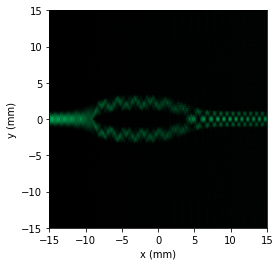

In [92]:
plot(IP,_cmap=cmap)

## Mach-Zender con doppia onda
Inseriemo due onde di diversa lunghezza onda e osserviamo che cosa succede al campo. le onde incontreranno un indice di rifrazione diverso in base al colore. La propagazione avverrà in maniera separata ma in seguito si sommeranno le intensità dei campi.<br>
I dati relativi la variazione dell'indice di rifrazione sono reperibili in https://refractiveindex.info/?shelf=glass&book=fused_silica&page=Malitson 

In [61]:
!wget https://refractiveindex.info/tmp/data/main/SiO2/Malitson.csv

--2020-05-28 16:48:07--  https://refractiveindex.info/tmp/data/main/SiO2/Malitson.csv
Resolving refractiveindex.info (refractiveindex.info)... 50.62.230.242
Connecting to refractiveindex.info (refractiveindex.info)|50.62.230.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2360 (2.3K) [text/csv]
Saving to: ‘Malitson.csv’

Malitson.csv        100%[===================>]   2.30K  --.-KB/s    in 0s      

2020-05-28 16:48:07 (66.5 MB/s) - ‘Malitson.csv’ saved [2360/2360]



In [68]:
## Caricamento dei dati 
# Colonna 1: lunghezza d'onda
# Colonna 2 indice di rifrazione
wl,n=np.loadtxt('Malitson.csv',delimiter=',',skiprows=1,unpack=True)
wl=wl*1e-6
print(wl.shape,n.shape)
print(wl)
print(n)

(101,) (101,)
[2.100e-07 2.174e-07 2.251e-07 2.330e-07 2.412e-07 2.497e-07 2.585e-07
 2.676e-07 2.770e-07 2.868e-07 2.969e-07 3.074e-07 3.182e-07 3.294e-07
 3.410e-07 3.530e-07 3.655e-07 3.783e-07 3.917e-07 4.055e-07 4.197e-07
 4.345e-07 4.498e-07 4.657e-07 4.821e-07 4.991e-07 5.167e-07 5.349e-07
 5.537e-07 5.732e-07 5.934e-07 6.143e-07 6.360e-07 6.584e-07 6.816e-07
 7.056e-07 7.305e-07 7.562e-07 7.829e-07 8.104e-07 8.390e-07 8.686e-07
 8.992e-07 9.308e-07 9.636e-07 9.976e-07 1.033e-06 1.069e-06 1.107e-06
 1.146e-06 1.186e-06 1.228e-06 1.271e-06 1.316e-06 1.362e-06 1.410e-06
 1.460e-06 1.512e-06 1.565e-06 1.620e-06 1.677e-06 1.736e-06 1.797e-06
 1.861e-06 1.926e-06 1.994e-06 2.064e-06 2.137e-06 2.212e-06 2.290e-06
 2.371e-06 2.454e-06 2.541e-06 2.630e-06 2.723e-06 2.819e-06 2.918e-06
 3.021e-06 3.128e-06 3.238e-06 3.352e-06 3.470e-06 3.592e-06 3.719e-06
 3.850e-06 3.986e-06 4.126e-06 4.271e-06 4.422e-06 4.578e-06 4.739e-06
 4.906e-06 5.079e-06 5.258e-06 5.443e-06 5.635e-06 5.833e-06 6.

In [0]:
def mach_zender_poli(Ip=1,l=cp.asarray([0.6e-6,4.27e-6]),
                     n0=cp.asarray([1.5,1.6]),w0=15e-6,name='heav'):
  tstart=time.time()
  l_i=len(l)
  IC=np.zeros((l_i,nx,nz),dtype=complex)
  IP=np.zeros((nx,nz))
  for i in range(l_i):
    print(f"Lunghezza d'onda={l[i]}")
    IC[i,:,:]=mach_zender(Ip,l[i],n0[i],w0,name=name,it=False)
  IP=abs(np.sum(IC,axis=0))**2
  print('\n'+'Durata integrazione '+f'{time.time()-tstart}\n')
  return(IP,IC)

In [80]:
IPp,ICp=mach_zender_poli(l=cp.asarray(wl[:50]),n0=cp.asarray(n[:50]),name='heav')
dnpo=cp.asnumpy(shape('heav',1))
IPp.shape

Lunghezza d'onda=2.0999999999999997e-07
Differenze energie -1.2040857200190658e-10
Integrazione completata!
Durata: 3.6537458896636963
Lunghezza d'onda=2.174e-07
Differenze energie -1.1308998182357755e-10
Integrazione completata!
Durata: 3.6932430267333984
Lunghezza d'onda=2.251e-07
Differenze energie -1.1088729934272124e-10
Integrazione completata!
Durata: 3.5965254306793213
Lunghezza d'onda=2.33e-07
Differenze energie -1.0932410532404901e-10
Integrazione completata!
Durata: 3.6055757999420166
Lunghezza d'onda=2.4119999999999996e-07
Differenze energie -1.1083045592386043e-10
Integrazione completata!
Durata: 3.589367151260376
Lunghezza d'onda=2.497e-07
Differenze energie -1.0729195309977513e-10
Integrazione completata!
Durata: 3.708531618118286
Lunghezza d'onda=2.585e-07
Differenze energie -1.1100098618044285e-10
Integrazione completata!
Durata: 3.6868703365325928
Lunghezza d'onda=2.676e-07
Differenze energie -1.1354472917446401e-10
Integrazione completata!
Durata: 3.602393865585327
Lu

(2048, 1600)

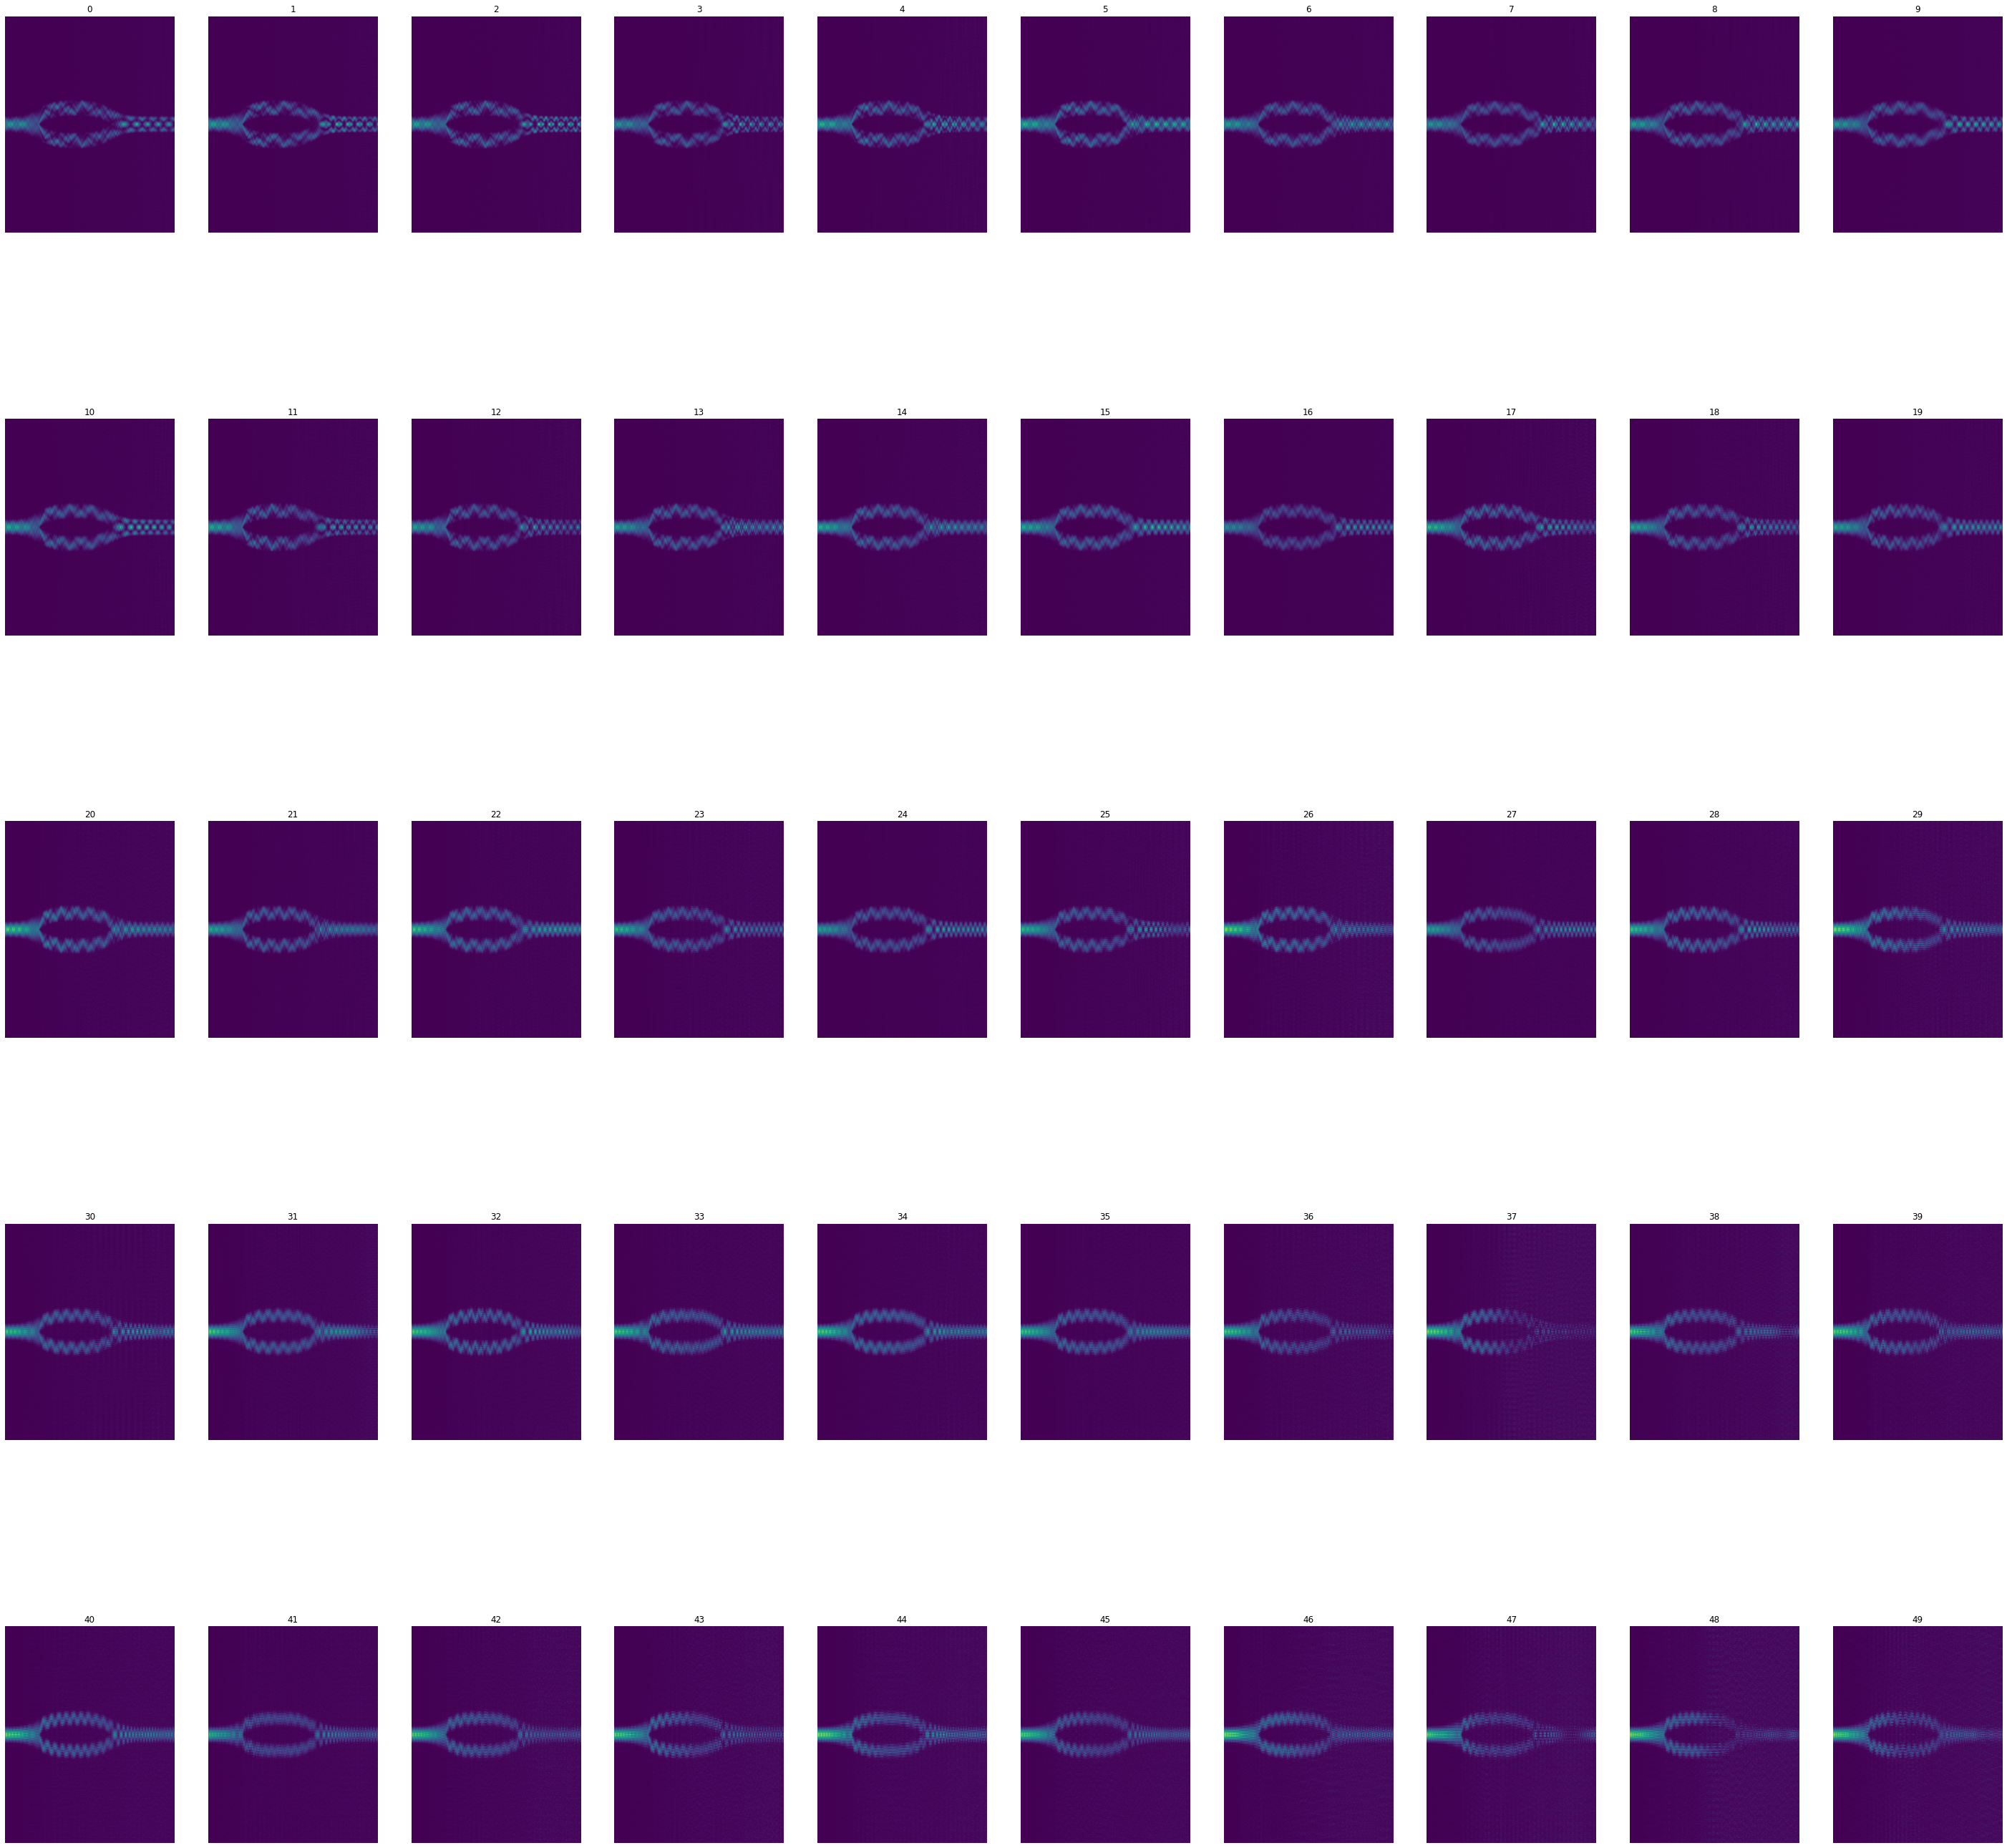

In [93]:
fig=plt.figure(figsize=(50,50))
for i in range(50):
  ax=fig.add_subplot(5,10,i+1)
  ax.axis('off')
  ax.imshow(abs(ICp[i,...])**2)
  ax.set_title(f'{i}')

In [0]:
fig.savefig('all_lamb.png')
fig.clear()

In [66]:
#Estrazione colore rosso e blu
print(wl[22],wl[33])
b=wavelength_to_cmap(wl[22]*1e9)
r=wavelength_to_cmap(wl[33]*1e9)
v=wavelength_to_cmap((0.4e-6)*1e9)

4.4979999999999996e-07 6.583999999999999e-07


In [99]:
#Estrazione campo e successiva analisi
IPrb,ICrb=mach_zender_poli(l=cp.asarray([wl[22],wl[33]]),
                          n0=cp.asarray([n[22],n[33]]))
ICr=ICrb[1,...]
ICb=ICrb[0,...]

Lunghezza d'onda=4.4979999999999996e-07
Differenze energie -1.106315039578476e-10
Integrazione completata!
Durata: 3.6354434490203857
Lunghezza d'onda=6.583999999999999e-07
Differenze energie -1.1007728062395472e-10
Integrazione completata!
Durata: 3.5789177417755127

Durata integrazione 7.372456312179565



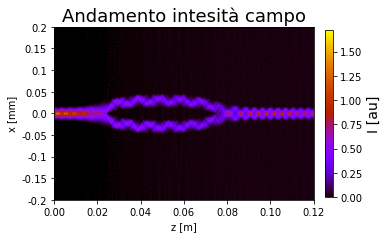

In [214]:
fig,ax=plt.subplots(figsize=(5,8))
col=ax.imshow(abs(ICb)**2,cmap=cm.gnuplot,extent=[0,0.12,-0.04,0.04])
ax.set(xlabel='z [m]',ylabel='x [mm]')
ax.set_yticklabels(np.arange(-2,2.5,0.5)/10)
ax.set_title('Andamento intesità campo',fontsize=18)
cba=fig.colorbar(col,fraction=0.03, pad=0.04)
cba.set_label(r'I [au]',fontsize=14)
#fig.savefig('int_tot.pdf')

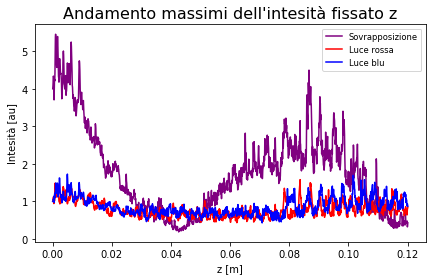

In [215]:
fig,ax=plt.subplots(figsize=(7,4))
ax.plot(zp,np.max(IPrb,axis=0),'purple',label='Sovrapposizione')
ax.plot(zp,np.max(abs(ICr)**2,axis=0),'r',label='Luce rossa')
ax.plot(zp,np.max(abs(ICb)**2,axis=0),'b',label='Luce blu')
ax.set(xlabel='z [m]',ylabel='Intesità [au]')
ax.legend(loc=1,fontsize='small')
ax.set_title("Andamento massimi dell'intesità fissato z",fontsize=16)
#fig.savefig('max_z.pdf')

In [0]:
def plot(Power, figsize=(7, 5),_cmap=cmap):
  fig, ax = plt.subplots(figsize=figsize)
  ax.grid(False)
  ax.imshow(Power, cmap=_cmap, extent=[0,0.12,-0.04,0.04])
  return fig, ax

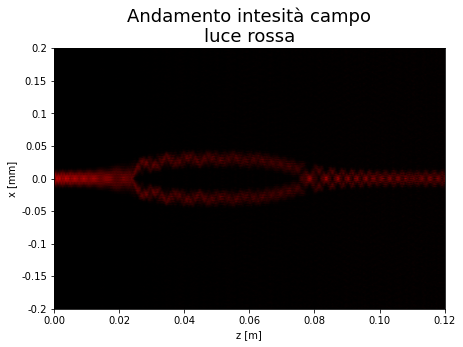

In [217]:
fig,ax=plot(abs(ICr)**2,_cmap=wavelength_to_cmap(wl[33]*1e9))
ax.set_yticklabels(np.arange(-2,2.5,0.5)/10)
ax.set(xlabel='z [m]',ylabel='x [mm]')
ax.set_title('Andamento intesità campo\nluce rossa',fontsize=18)
#fig.savefig('int_red.pdf')

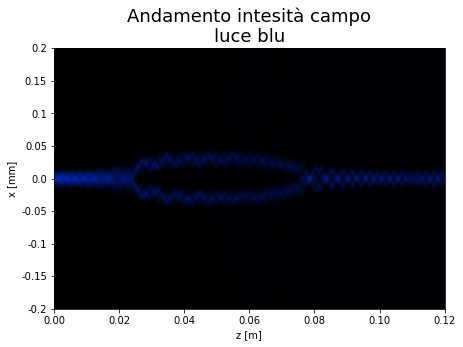

In [213]:
fig,ax=plot(abs(ICr)**2,_cmap=wavelength_to_cmap(wl[22]*1e9))
ax.set_yticklabels(np.arange(-2,2.5,0.5)/10)
ax.set(xlabel='z [m]',ylabel='x [mm]')
ax.set_title('Andamento intesità campo\nluce blu',fontsize=18)
#fig.savefig('int_blue.pdf')

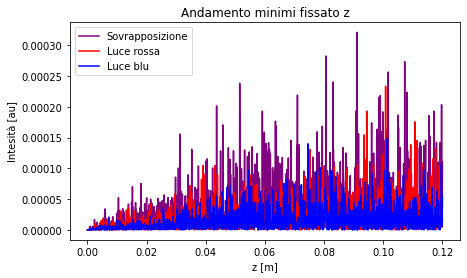

In [135]:
fig,ax=plt.subplots(figsize=(7,4))
ax.plot(zp,np.min(IPrb,axis=0),'purple',label='Sovrapposizione')
ax.plot(zp,np.min(abs(ICr)**2,axis=0),'r',label='Luce rossa')
ax.plot(zp,np.min(abs(ICb)**2,axis=0),'b',label='Luce blu')
ax.set(xlabel='z [m]',ylabel='Intesità [au]',title='Andamento minimi fissato z')
ax.legend()

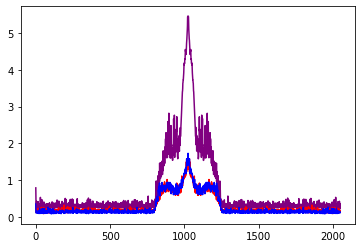

In [126]:
plt.plot(np.max(IPrb,axis=1),'purple')
plt.plot(np.max(abs(ICr)**2,axis=1),'r')
plt.plot(np.max(abs(ICb)**2,axis=1),'b')

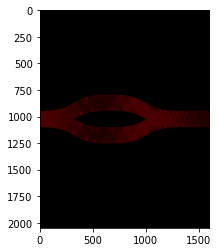

In [0]:
## Sfasamento nella guida
## ci sono degli errori di integrazione quindi gli eliminiamo
real_sfa=(np.conjugate(ICr)*ICb).real/2/abs(ICr)/abs(ICb)
find_sfa=(dnpo!=0).T
find_sfa.shape
real_sfa_plot=real_sfa.copy()
real_sfa_plot[~find_sfa]=-1.2
plt.imshow(real_sfa_plot,cmap=v)

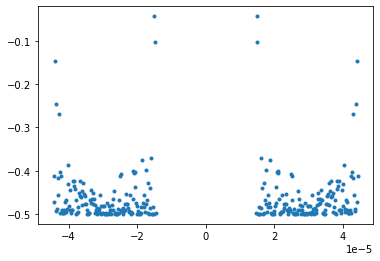

In [0]:
plt.plot(xp[find_sfa[:,560]],real_sfa[find_sfa[:,560],560],'.')
#plt.plot(xp,dnpo[560,:])

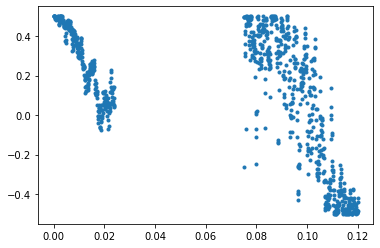

In [0]:
plt.plot(zp[find_sfa[1024,:]],real_sfa[1024,find_sfa[1024,:]],'.')

Text(0.5, 1.0, 'Andamento del coseno\n dello sfasamento tra i campi')

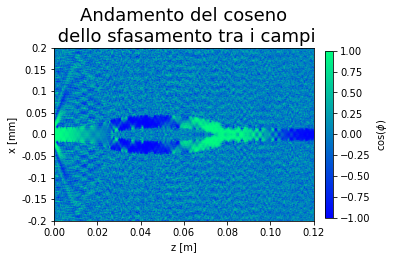

In [220]:
#Andamento dello sfasamento
fig,ax=plt.subplots(figsize=(5,8))
col=ax.imshow((IPrb-abs(ICr)**2-abs(ICb)**2)/2/abs(ICr)/abs(ICb),
              cmap=cm.winter,extent=[0,0.12,-0.04,0.04])
cb=fig.colorbar(col,fraction=0.03, pad=0.04)
ax.set_yticklabels(np.arange(-2,2.5,0.5)/10)
ax.set(xlabel='z [m]',ylabel='x [mm]')
cb.set_label(r'$\cos(\phi)$')
ax.set_title("Andamento del coseno\n dello sfasamento tra i campi",fontsize=18)
#fig.savefig('sfas_cos.pdf')

Text(0.5, 1.0, 'Intesnità campo a z=8e-05')

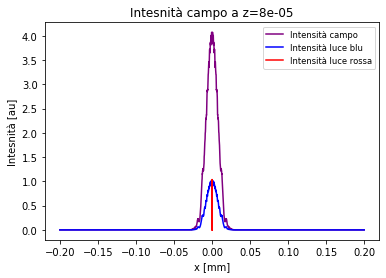

In [236]:
fig,ax=plt.subplots()
ax=plot_subse(1,ax)
ax.legend(loc=0,fontsize='small')
ax.set(xlabel='x [mm]',ylabel="Intesnità [au]")
ax.set_title(f'Intesnità campo a z={round(zp[1],5)}')

In [0]:
def plot_subse(z_p,ax):
  if ax==None:
    fig,ax=plt.subplots(figsize=(4,3))
  ax.plot(xp*1e3,IPrb[:,z_p],'purple',label='Intensità campo')
  ax.plot(xp*1e3,abs(ICb[:,z_p])**2,'b',label='Intensità luce blu')
  ax.plot(xp,abs(ICr[:,z_p])**2,'r',label='Intensità luce rossa')
  
  return(ax)

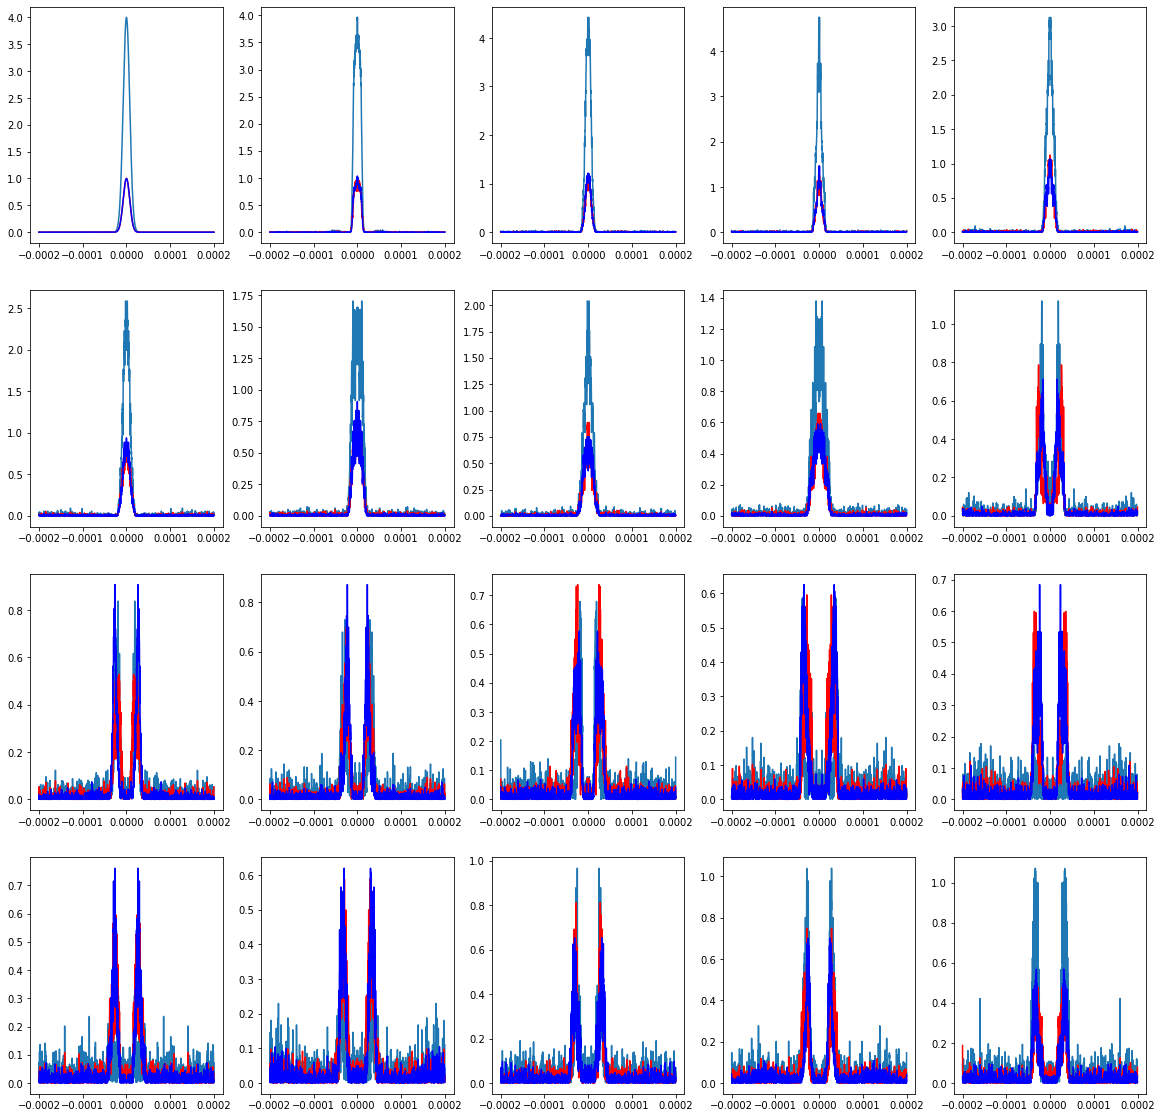

In [0]:
fig=plt.figure(figsize=(20,20))
for i in range(20):
  ax=fig.add_subplot(4,5,i+1)
  plot_subse(i*40,ax)

In [0]:
#Funzione di plot sfasamenti

def plot_sfa(IPp,ICp,dn,z_p):
  plt.plot(xp,dn[z_p,:],'black')
  plt.plot(xp,IPp[:,z_p])
  for i in range(ICp.shape[0]):
    plt.plot(xp,ICp[i,:,z_p].real)